In [24]:
import pandas as pd
import numpy as np
import json

#Loading additional helper functions not shown here but provided in the folder
%run nlp_utils_news.ipynb

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
#Load the JSON Data into a df

data = []

for line in open(r'/home/saimir/git/personal_data_science_projects/mulitclass_text_class/ma.json', 'r'):
    print(line)
    data.append(json.loads(line))

content, label = [], []
for each in data:
    
    content.append(each['content'])
    label.append(each['annotation']['label'][0])
    
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']
df.head()

{"content": "fixes  35159  x000D \n x000D \nWhen update using nested attributes is performed on the field which has  has rich text  then field value was not getting updated   x000D \n x000D \n    x000D \nclass Message   ApplicationRecord x000D \n      also occurs with  has many  x000D \n    has one  post x000D \n x000D \n    accepts nested attributes for  post x000D \nend x000D \n x000D \nclass Post   ApplicationRecord x000D \n    has rich text  content x000D \nend x000D \n    x000D \n x000D \nFollowing test is failing on master  This PR fixes the issue  x000D \n    x000D \ntest  can update post from within message  do x000D \n    message   Message create  title   Seasons   x000D \n    post   message create post  x000D \n x000D \n      test updating post directly from the message x000D \n    message update  post attributes    content   Test content   id  post id    x000D \n x000D \n      it appears that everything updated  x000D \n    assert equal  Test content   message post content t

,content,label
0,fixes 35159 x000D \n x000D \nWhen update usi...,apology
1,Summary x000D \n x000D \nThis was a very ...,action
2,While looking at the comment https github co...,thank
3,Summary x000D \nIndentation in these examp...,acknowledgement
4,This is a small change of guide x000D \n x000...,acknowledgement


In [25]:
from nltk import word_tokenize, sent_tokenize

In [26]:
#Apply the function to preprocess the text. Tokenize, lower, expand contactions, lemmatize, remove punctuation, numbers and stop words

df['clean_text'] = df['content'].apply(word_tokenize)
df.head()

,content,label,clean_text,word_count,label_num
1553,Thanks for the review x000D \n x000D \n postg...,acknowledgement,"[Thanks, for, the, review, x000D, x000D, postg...",63,0
1568,Gotcha I m closing this PR for now Thanks f...,acknowledgement,"[Gotcha, I, m, closing, this, PR, for, now, Th...",20,0
772,Can I backport this to Rails 5 1 and 5 2 What...,acknowledgement,"[Can, I, backport, this, to, Rails, 5, 1, and,...",17,0
405,Summary x000D \n x000D \nFixes https git...,acknowledgement,"[Summary, x000D, x000D, Fixes, https, github, ...",31,0
290,Adds attachments to the form to create new inb...,acknowledgement,"[Adds, attachments, to, the, form, to, create,...",39,0


In [27]:
#Top 20 most frequent words for all the articles

cl_text_list = df['clean_text'].tolist()
wf = word_freq(cl_text_list, 40)
wf.head(40)

,0,1
0,x000D,3020
1,the,1220
2,to,970
3,test,833
4,a,494
5,I,470
6,in,451
7,rb,440
8,is,421
9,rails,416


In [28]:
#Avg word count by category

df['word_count'] = df['content'].apply(word_count)
avg_wc = df.groupby('label').mean().reset_index()
avg_wc[['label','word_count']]

,label,word_count
0,acknowledgement,96.89
1,action,81.10
2,apology,145.04
3,citation,63.41


In [31]:
#Preparing the dataframes

#Splitting the df into the different categories
df_business = df.loc[df['label'] == 'acknowledgement'] 
df_sports = df.loc[df['label'] =='action']
df_scitech = df.loc[df['label'] == 'apology'] 
df_world = df.loc[df['label'] =='citation']

#Randomly sampling business and sports to create imbalanced classes
df_business = df_business.sample(n=200, random_state=3)
df_sports = df_sports.sample(n=150, random_state=3)

#Holding out 5 articles from each class for prediction at the end
df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

#Appending the dfs back together
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

#Turning the labels into numbers
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

display(df.groupby(['label'])['content'].count())
display(df_holdout.groupby(['label'])['content'].count())
display(df['label'].unique())
display(df['label_num'].unique())

label
acknowledgement    195
action             145
apology             20
citation            58
Name: content, dtype: int64

label
acknowledgement    5
action             5
apology            5
citation           5
Name: content, dtype: int64

array(['acknowledgement', 'action', 'apology', 'citation'], dtype=object)

array([0, 1, 2, 3])

In [30]:
len(df_business)

295

In [32]:
#Top 15 words by category. Taking bigrams into account

top_n = 15

text_bus = df_business['clean_text'].tolist()
text_sci_t = df_scitech['clean_text'].tolist()
text_sports = df_sports['clean_text'].tolist()
text_world = df_world['clean_text'].tolist()

bus = word_freq_bigrams(text_bus, top_n=top_n)
sci_t = word_freq_bigrams(text_sci_t, top_n=top_n)
sports = word_freq_bigrams(text_sports, top_n=top_n)
world = word_freq_bigrams(text_world, top_n=top_n)

df_wf = pd.concat([bus, sci_t, sports, world], axis=1)
cols = ['acknowledgement', 'count', 'apology', 'count', 'action', 'count', 'citation', 'count']
df_wf.columns = cols
df_wf

,acknowledgement,count,apology,count,action,count,citation,count
0,x000D_x000D,225,the,20,x000D_x000D,162,to,62
1,x000D,198,x000D,18,x000D,149,the,56
2,test_rb,182,x000D_x000D,18,the,105,this,38
3,the,149,to,17,to,89,x000D_x000D,37
4,rb_test,134,this,12,a,68,x000D,31
5,to,132,a,11,and,67,is,30
6,test_controller,98,that,10,that,46,I,30
7,and,81,is,10,is,46,and,30
8,a,74,I,10,for,43,a,29
9,is,66,with,8,this,40,that,27


In [11]:
#Top 15 bigrams by category

bus_bigrams = bigram_freq(text_bus, top_n = top_n)
sci_t_bigrams = bigram_freq(text_sci_t, top_n = top_n)
sports_bigrams = bigram_freq(text_sports, top_n = top_n)
world_bigrams = bigram_freq(text_world, top_n = top_n)

df_bigram_wf = pd.concat([bus_bigrams, sci_t_bigrams, sports_bigrams, world_bigrams], axis=1)
df_bigram_wf.columns = cols
df_bigram_wf

,acknowledgement,count,apology,count,action,count,citation,count
0,xd_xd,311,xd_xd,47,xd_xd,301,xd_xd,38
1,test_rb,188,xd_master,12,customer_balance,53,com_rail,16
2,rb_test,128,xd_advance,12,com_rail,47,http_github,10
3,test_controller,100,retain_xd,9,http_github,40,action_mailbox,7
4,test_dispatch,56,±_m,6,end_xd,31,https_github,7
5,com_rail,47,comparison_xd,5,xd_end,29,rail_pull,7
6,summary_xd,45,error_message,5,rail_rail,24,rail_blob,6
7,http_github,25,summary_xd,4,github_com,21,summary_xd,4
8,don_t,25,dup_k,4,rail_blob,20,rubyonrails_org,4
9,m_time,24,account_firm,4,rail_pull,20,rail_commit,3


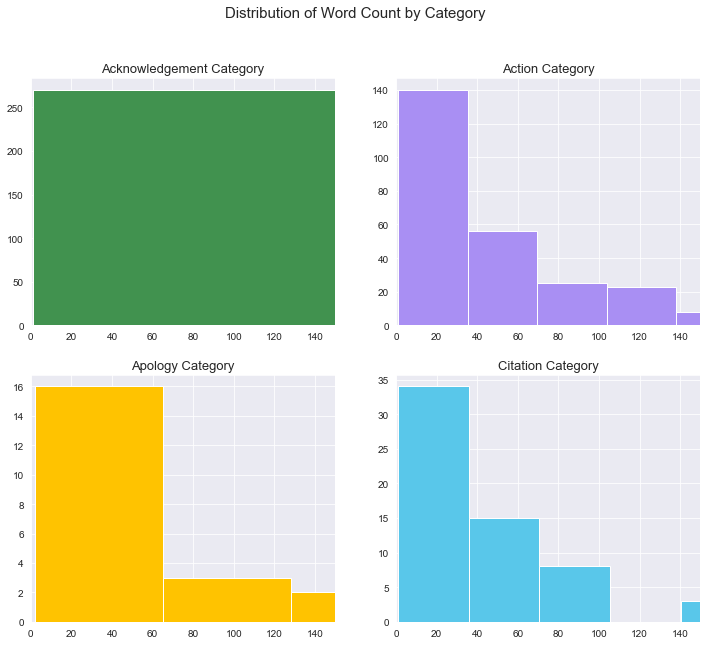

In [12]:
#Plot the distribution of word count by article

fig, ax = plt.subplots(2, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by Category', fontsize=15)

bins = 30

ax[0, 0].hist(df_business['word_count'], bins = bins, color = '#41924F')
ax[0, 0].set_title('Acknowledgement Category', fontsize = 13)
ax[0, 0].set_xlim(0, 150)

ax[1, 0].hist(df_scitech['word_count'], bins = bins, color = '#FFC300')
ax[1, 0].set_title('Apology Category', fontsize = 13)
ax[1, 0].set_xlim(0, 150)

ax[0, 1].hist(df_sports['word_count'], bins = bins, color = '#a98ff3')
ax[0, 1].set_title('Action Category', fontsize = 13)
ax[0, 1].set_xlim(0, 150)

ax[1, 1].hist(df_world['word_count'], bins = bins, color = '#59C7EA')
ax[1, 1].set_title('Citation Category', fontsize = 13)
ax[1, 1].set_xlim(0, 150)

plt.show()

In [13]:
#Creating the features (tf-idf weights) for the processed text

texts = df['clean_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

print (X.shape)
print(y.shape)

(663, 2605)
(663,)


In [14]:
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(663, 100)

In [15]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name,accuracy_score,precision_score,recall_score,f1_score
5,Gaussian Naive Bayes,0.40,0.29,0.29,0.29
2,Random Forest,0.42,0.46,0.25,0.24
6,K Nearest Neighbor,0.43,0.28,0.26,0.24
3,Decsision Tree,0.38,0.24,0.23,0.23
4,AdaBoost,0.39,0.24,0.24,0.23
1,Stochastic Gradient Descent,0.39,0.20,0.22,0.20
0,Dummy,0.36,0.20,0.21,0.20


In [26]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#SGD
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.0min finished


In [27]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#RF
bootstrap = [True, False]
max_depth = [10, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [800, 1400, 2000]
random_state = [3]

clf = RandomForestClassifier()

params = dict(bootstrap = bootstrap,
              max_depth = max_depth,
              max_features = max_features,
              min_samples_leaf = min_samples_leaf,
              n_estimators = n_estimators,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

rf_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 27.7min finished


In [56]:
#Define the best models with the selected params from the grdsearch
#Gridsearch was done on a virtual machine outisde of this notebook
#Normally you can just say 'best_model = gridsearch.best_params_' 
#to use the best parameters from the gridsearch

sgd_best_model = SGDClassifier(alpha=1e-06,
                               loss='log',
                               max_iter=1000,
                               penalty='l2',
                               learning_rate = 'constant',
                               eta0 = .1,
                               random_state = 3,
                               tol=None)

rf_best_model = RandomForestClassifier(bootstrap = False,
                                       max_depth = 50,
                                       max_features = 'auto',
                                       min_samples_leaf = 1,
                                       n_estimators = 1400,
                                       random_state=3)

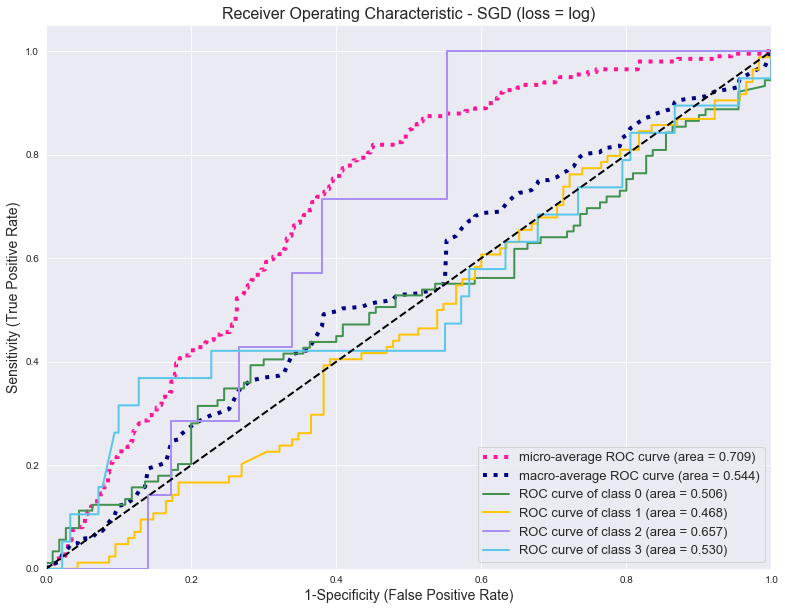

In [89]:
#Plot AUC - SGD

#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(sgd_best_model)

y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

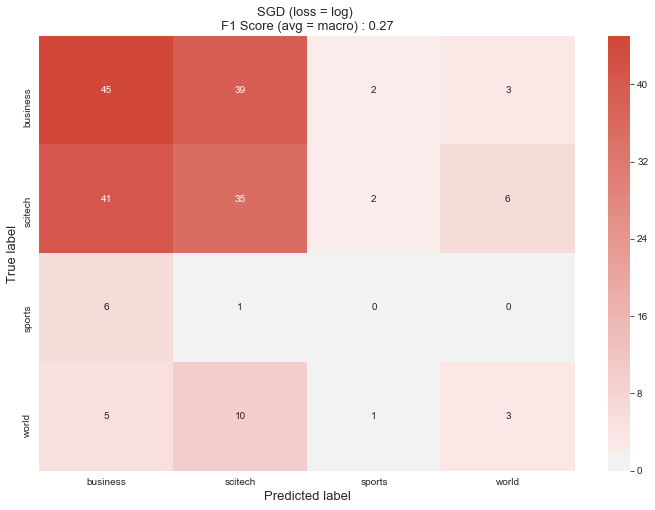

In [90]:
#Confusion Matrix - SGD

#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
#Fit the training data
sgd_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = sgd_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['business','scitech','sports', 'world'], 
                     columns = ['business','scitech','sports', 'world'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

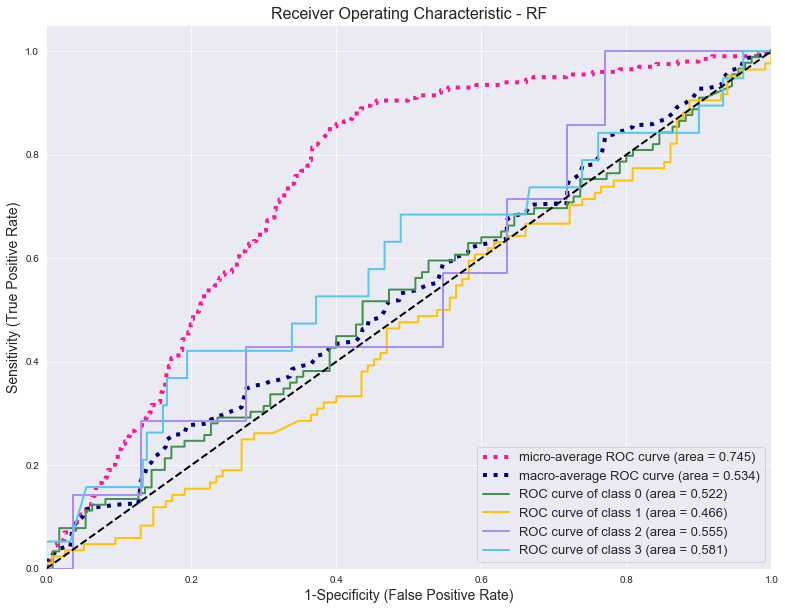

In [91]:
#Plot AUC - RF

#Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(rf_best_model)

y_score = rf_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - RF', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

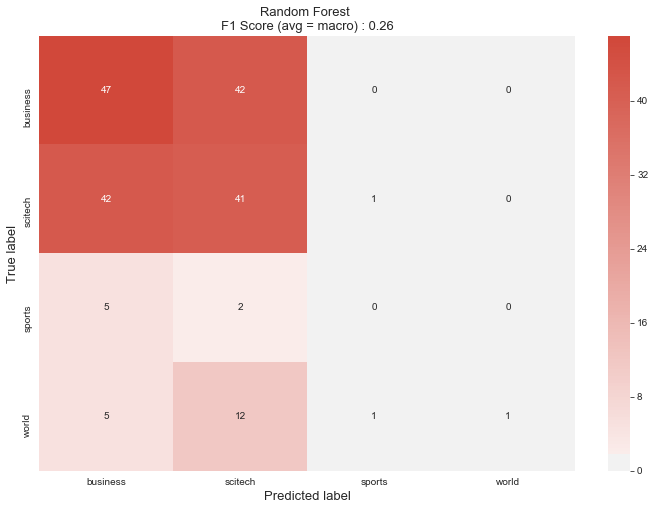

In [47]:
#Confusion Matrix - RF

#Fit the training data
rf_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = rf_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['ackownledgement','scitech','sports', 'world'], 
                     columns = ['ackownledgement','scitech','sports', 'world'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Random Forest \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

In [93]:
#Putting it all together to make predictions on the unseen text

#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout['clean_text'].astype('str') 

print(df_holdout)

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_sgd'] = sgd_best_model.predict(X_unseen)
df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {'Business': 0,
                  'SciTech': 1,
                  'Sports': 2,
                  'World': 3}

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout.drop('clean_text', 1)
df_holdout = df_holdout[['content', 'label', 'pred_sgd', 'pred_rf', 'correct']]

df_holdout

KeyError: 'clean_text'

In [94]:
#Using the original full unsampled dataset for predictions

data = []

for line in open(r'/home/saimir/git/personal_data_science_projects/mulitclass_text_class/ma.json', 'r'):
    data.append(json.loads(line))

content, label = [], []
for each in data:
    content.append(each['content'])
    label.append(each['annotation']['label'][0])
    
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']

#Splitting the df into business and sports articles
df_business = df.loc[df['label'] == 'aknowledgement'] 
df_sports = df.loc[df['label'] =='action']
df_scitech = df.loc[df['label'] == 'apology'] 
df_world = df.loc[df['label'] =='citation']

#Holding out 5 articles from each class for prediction at the end
df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

#Appending the dfs back together
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

df['clean_text'] = df['content'].apply(process_text) 

#Turning the labels into numbers
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

#Get the text of the 5 articles we held out from each of the categories in the beginning
df_holdout['clean_text'] = df_holdout['content'].apply(process_text) 
unseen = df_holdout['clean_text'].astype('str') 

#Creating the features (tf-idf weights) for the processed text
texts = df['clean_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

#Dimenionality reduction. Only using the 100 best features
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)

#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
rf_best_model.fit(X, y)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_sgd'] = sgd_best_model.predict(X_unseen)
df_holdout['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {'Business': 0,
                  'SciTech': 1,
                  'Sports': 2,
                  'World': 3}

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout.drop('clean_text', 1)
df_holdout = df_holdout[['content', 'label', 'pred_sgd', 'pred_rf', 'correct']]

df_holdout

,content,label,pred_sgd,pred_rf,correct
1,Summary x000D \n x000D \nThis was a very ...,action,0,0,nan
6,Background x000D \n x000D \nI had first adde...,action,0,0,nan
13,Fixes issue https github com rails rails iss...,action,0,0,nan
25,Summary x000D \n x000D \nZeitwork uses a d...,action,0,0,nan
31,I want to start reducing the calls to lookup ...,action,0,0,nan
0,fixes 35159 x000D \n x000D \nWhen update usi...,apology,0,0,nan
47,This reverts a fix that broke schemas in SQLit...,apology,0,0,nan
84,Closes https github com rails rails issues 3...,apology,0,0,nan
103,This reverts commit 38f9e41f2c4b64377ffb036c53...,apology,0,0,nan
111,I applied the following migration x000D \n x0...,apology,0,0,nan
